In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
mnist = fetch_openml('mnist_784', version=1)

In [2]:
X, y= mnist['data'], mnist['target']

X_numpy = X.to_numpy()

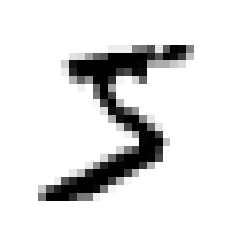

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X_numpy[0]
image = some_digit.reshape(28,28)

plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
import numpy as np
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
from sklearn.linear_model import SGDClassifier

std_clf = SGDClassifier(random_state = 42)
std_clf.fit(X_train, y_train_5)
std_clf.predict(X_test)

array([False, False, False, ..., False,  True, False])

In [25]:
from sklearn.model_selection import cross_val_score, cross_val_predict
y_train_pred = cross_val_predict(std_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
y_scores = cross_val_predict(std_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

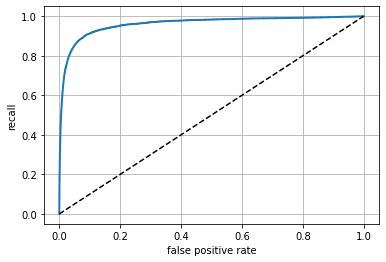

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2, label=None)
plt.ylabel('recall')
plt.xlabel('false positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.grid()
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier

rdf = RandomForestClassifier(random_state = 42)

rdf_pred_score = cross_val_predict(rdf, X_train, y_train_5, cv=3, method='predict_proba')
# SE TOMA EL [:, 1] PORQUE EN ESA COLUMNA ESTAN LOS PUNTAJES (O PROBABILIDADES DE CLASIFICACIÓN POSITIVA)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,rdf_pred_score[:, 1])

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, rdf_pred_score[:, 1])

0.9983436731328145

In [35]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
y_pred = ovo_clf.predict(X_test)

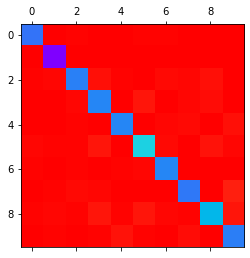




 [[ 951    0    7    1    1    8    7    1    2    2]
 [   0 1120    4    3    0    1    2    1    4    0]
 [   7   12  928   24    6    2   14   10   25    4]
 [   1    2   11  920    2   35    2   12   21    4]
 [   1    1    7    0  919    1    9   15    3   26]
 [   9    5    5   35    4  777   16    2   29   10]
 [   7    3    7    1    5   11  922    0    2    0]
 [   1    5   15   10    4    1    0  942    2   48]
 [   8    9    8   31    8   31   10    5  832   32]
 [   3    6    1    8   28    5    1   20    3  934]]


In [59]:
from sklearn.metrics import confusion_matrix

cf_mx = confusion_matrix(y_test, y_pred)
plt.matshow(cf_mx, cmap=plt.cm.rainbow_r)
plt.show()
print('\n\n\n', cf_mx)

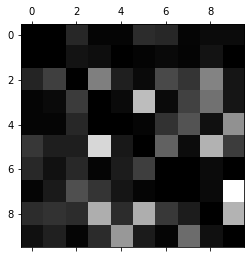

In [61]:
sums_mx = cf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = cf_mx / sums_mx
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [13]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [20]:
# IMPLEMENTANDO LA CLASIFICACIÓN DE MULTIPLES CLASES BINARIAS CON KNN
from sklearn.neighbors import KNeighborsClassifier

KN = KNeighborsClassifier()
KN.fit(X_train, y_multilabel)
KN.predict([some_digit])

array([[False,  True]])

In [30]:
# CORROBORANDO EL PUNTAJE F1 PARA CADA UNA DE LAS CLASES (try: average="weighted")
y_train_knn_pred = cross_val_predict(KN, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [64]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [81]:
some_index = X_test_mod.to_numpy()[1]
KN.fit(X_train_mod, y_train_mod)
clean_digit = KN.predict([X_test_mod.iloc[1]])
# plot_digit(clean_digit)

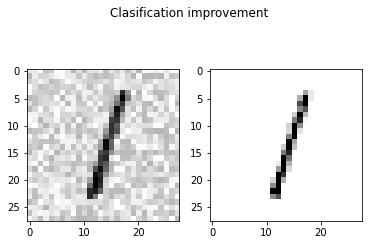

In [98]:
# FUNCIÓN PARA PLOTEAR EL DIGITO QUE SE MODIFICÓ Y EL QUE SE PREDICE, FALTA AJUSTAR QUE SEA CORRESPONDIENTE AL INDEX
def plot_digit_vs_pred(idx: int):
    dig = X_test_mod.to_numpy()[idx].reshape(28,28)
    pred = KN.predict([X_test_mod.iloc[idx]]).reshape(28,28)
#     HACER LOS PLOTS
    fig, axs = plt.subplots(1,2)
    fig.suptitle('Clasification improvement')
    axs[0].imshow(dig, cmap=plt.cm.binary, interpolation='nearest')
    axs[1].imshow(pred, cmap=plt.cm.binary, interpolation='nearest')
    
plot_digit_vs_pred(2)

In [103]:
# HACIENDO LA PREDICCIÓN DE TODO EL DATASET CON GRIDSEARCH
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid =[{'weights': ["uniform", "distance"], 
              'n_neighbors': [3, 4, 5]}]

knn = KNeighborsClassifier()
knn_grd = GridSearchCV(knn, param_grid, cv=2, verbose=3)
knn_grd.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ....n_neighbors=3, weights=uniform;, score=0.966 total time=  25.8s
[CV 2/2] END ....n_neighbors=3, weights=uniform;, score=0.965 total time=  25.6s
[CV 1/2] END ...n_neighbors=3, weights=distance;, score=0.967 total time=  25.6s
[CV 2/2] END ...n_neighbors=3, weights=distance;, score=0.966 total time=  22.6s
[CV 1/2] END ....n_neighbors=4, weights=uniform;, score=0.962 total time=  27.7s
[CV 2/2] END ....n_neighbors=4, weights=uniform;, score=0.963 total time=  29.8s
[CV 1/2] END ...n_neighbors=4, weights=distance;, score=0.968 total time=  26.3s
[CV 2/2] END ...n_neighbors=4, weights=distance;, score=0.966 total time=  24.7s
[CV 1/2] END ....n_neighbors=5, weights=uniform;, score=0.963 total time=  26.1s
[CV 2/2] END ....n_neighbors=5, weights=uniform;, score=0.964 total time=  25.2s
[CV 1/2] END ...n_neighbors=5, weights=distance;, score=0.965 total time=  25.8s
[CV 2/2] END ...n_neighbors=5, weights=distance;,

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [105]:
print(knn_grd.best_params_)
print(knn_grd.best_score_)

{'n_neighbors': 4, 'weights': 'distance'}
0.96685


In [108]:
# PROBANDO EL DOBLE ASTERISCO ** INGRESA EL RESULTADO DE AQUELLO QUE ESTA AFECTANDO
knn_opt = KNeighborsClassifier(**knn_grd.best_params_)
knn_opt.fit(X_train, y_train)
y_pred_best_params = knn_opt.predict(X_test)

In [109]:
accuracy_score(y_test, y_pred_best_params)

0.9714